In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [3]:
vels_filtered = xr.open_zarr('/swot/SUM02/spencer/daily_filt/filtered_vels.zarr')
vels_unfiltered = xr.open_zarr('/swot/SUM02/spencer/daily_filt/unfiltered_vels.zarr')
eta_unfiltered = xr.open_zarr('/swot/SUM02/spencer/daily_filt/unfiltered_eta_nom.zarr')
eta_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_mean.zarr')

u_filt = vels_filtered.u.isel(time=slice(1,200))
v_filt = vels_filtered.v.isel(time=slice(1,200))

u_unfilt = vels_unfiltered.u.isel(time=slice(1,200))
v_unfilt = vels_unfiltered.v.isel(time=slice(1,200))

eta_unfilt = (eta_unfiltered.eta+eta_mean.Eta).isel(time=slice(1,200))

indir = '/swot/SUM01/LLC/llc_4320_agulhas/'
depth =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/Depth.data', dtype='>f4').reshape(2160,2160)

In [4]:
for i in range(0,71):
    nt = 10368 + 42*144 +i*24*144
    ds = xr.open_dataset(indir + 'llc_4320_agulhas.%010d.nc' %nt)
    Temp = ds.Theta.isel(k=0)
    if i==0:
        SST = Temp
    else:
         SST=xr.concat([SST, Temp], dim="time")   

In [5]:
steric2 = xr.open_zarr('/swot/SUM02/spencer/steric_inc_mean.zarr')
steric_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/steric_mean.zarr')
eta_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_mean.zarr')

eta_eul = (steric2.steric-steric_mean.steric + eta_mean.Eta).isel(time=slice(0,1752))

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/array/core.py:4048: PerformanceWarning: Increasing number of chunks by factor of 32
  **blockwise_kwargs,


In [6]:
eta_unfilt

<xarray.DataArray (time: 70, i: 2160, j: 2160)>
dask.array<getitem, shape=(70, 2160, 2160), dtype=float64, chunksize=(1, 180, 180), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) float64 0.0 1.0 2.0 3.0 ... 2.157e+03 2.158e+03 2.159e+03
  * i        (i) int64 1080 1081 1082 1083 1084 ... 3235 3236 3237 3238 3239
    niter    int64 ...
  * time     (time) int64 0 86400 172800 259200 ... 5788800 5875200 5961600
    x0       (i) float64 dask.array<chunksize=(2160,), meta=np.ndarray>
    y0       (j) float64 dask.array<chunksize=(2160,), meta=np.ndarray>
    z0       float64 ...
    face     int64 ...
    x        (j, i) float32 dask.array<chunksize=(270, 540), meta=np.ndarray>
    y        (j, i) float32 dask.array<chunksize=(270, 540), meta=np.ndarray>

In [25]:
depth_array = xr.DataArray(depth,dims=['j','i'])
mario_dataset = vels_filtered.isel(time=slice(1,200)).astype('float32').rename({'u': 'u_filtered','v': 'v_filtered'})
mario_dataset = mario_dataset.merge(vels_unfiltered.isel(time=slice(1,200)).astype('float32').rename({'u': 'u_unfiltered','v': 'v_unfiltered'}))
mario_dataset = mario_dataset.merge(eta_unfilt.rename('ssh_unfiltered').astype('float32'))
mario_dataset = mario_dataset.drop_vars('time').merge(SST.isel(time=slice(0,70)).astype('float32'))
mario_dataset = mario_dataset.assign_coords(Depth=(('j', 'i'), depth.astype('float32')))

mario_dataset.x0.attrs['units']='degrees_east'
mario_dataset.x0.attrs['long_name']='longitude'
mario_dataset.y0.attrs['units']='degrees_north'
mario_dataset.y0.attrs['long_name']='latitude'
mario_dataset.z0.attrs['units']='meters'
mario_dataset.z0.attrs['long_name']='depth'
mario_dataset.Depth.attrs['long_name']='depth of the ocean'
mario_dataset.Depth.attrs['units']='meters'
mario_dataset=mario_dataset.drop_vars('niter')

mario_dataset.time.attrs['units_comment']= 'ns since 2011-09-10'

mario_dataset.u_unfiltered.attrs['units'] = 'm/s'
mario_dataset.v_unfiltered.attrs['units'] = 'm/s'
mario_dataset.u_filtered.attrs['units'] = 'm/s'
mario_dataset.v_filtered.attrs['units'] = 'm/s'
mario_dataset.ssh_unfiltered.attrs['units'] = 'meters'


mario_dataset.u_unfiltered.attrs['long_name'] = 'Unfiltered zonal velocity on tracer points'
mario_dataset.v_unfiltered.attrs['long_name'] = 'Unfiltered meridional velocity on tracer points'
mario_dataset.u_filtered.attrs['long_name'] = 'Lagrangian filtered zonal velocity on tracer points'
mario_dataset.v_filtered.attrs['long_name'] = 'Lagrangian filtered meridional velocity on tracer points'
mario_dataset.ssh_unfiltered.attrs['long_name'] = 'Steric sea surface height'

from datetime import date
today = date.today()

mario_dataset.attrs['title'] = '70 days of daily surface velocity and steric ssh, both Lagrangian filtered and unfiltered'
mario_dataset.attrs['institution'] = 'LDEO'
mario_dataset.attrs['source'] = 'MITgcm LLC4320, with filtering methods applied to some of the data'
mario_dataset.attrs['history'] = 'This version created ' + str(today) + ' by C. Spencer Jones'
mario_dataset.attrs['references'] = 'Jones, C. S., Xiao, Q. , Abernathey, R. P. , Smith, K. S. Separating balanced and unbalanced flow at the surface of the Agulhas region using Lagrangian filtering (in prep)'
mario_dataset.chunk({"time": 1, "i": 2160,"j":2160}).to_zarr('/swot/SUM02/spencer/for_qiyu/for_mario/surf_filt_Agulhas_LLC4320.zarr')

In [27]:
ds1 = xr.open_zarr('/swot/SUM02/spencer/for_qiyu/for_mario/surf_filt_Agulhas_LLC4320.zarr')
ds1

<xarray.Dataset>
Dimensions:         (i: 2160, j: 2160, time: 70)
Coordinates:
    Depth           (j, i) float32 dask.array<chunksize=(2160, 2160), meta=np.ndarray>
    face            int64 ...
  * i               (i) int64 1080 1081 1082 1083 1084 ... 3236 3237 3238 3239
    iter            (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j               (j) float64 0.0 1.0 2.0 ... 2.157e+03 2.158e+03 2.159e+03
    k               int64 ...
  * time            (time) timedelta64[ns] 4 days 18:00:00 ... 73 days 18:00:00
    x               (j, i) float32 dask.array<chunksize=(270, 540), meta=np.ndarray>
    x0              (i) float64 dask.array<chunksize=(2160,), meta=np.ndarray>
    y               (j, i) float32 dask.array<chunksize=(270, 540), meta=np.ndarray>
    y0              (j) float64 dask.array<chunksize=(2160,), meta=np.ndarray>
    z0              float64 ...
Data variables:
    Theta           (time, j, i) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    ssh_unfiltered  (time, i, j) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    u_filtered      (time, i, j) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    u_unfiltered    (time, i, j) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    v_filtered      (time, i, j) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    v_unfiltered    (time, i, j) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
Attributes:
    history:      This version created 2022-04-20 by C. Spencer Jones
    institution:  LDEO
    references:   Jones, C. S., Xiao, Q. , Abernathey, R. P. , Smith, K. S. S...
    source:       MITgcm LLC4320, with filtering methods applied to some of t...
    title:        70 days of daily surface velocity and steric ssh, both Lagr...

In [ ]:
grid = Grid(ds, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})
uvel_centered = grid.interp(ds.U.isel(k=0),'X')
#uvel_centered = uvel_centered.assign_coords(x=(["j","i"], xc)).assign_coords(y=(["j","i"], yc))

In [ ]:
(uvel_centered-u_unfilt.isel(time=0)).plot()

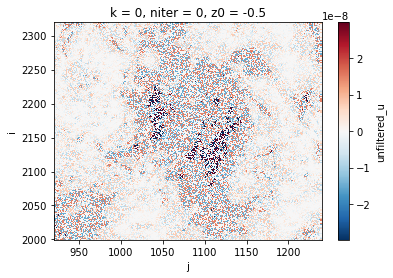

In [34]:
(ds1.unfiltered_u.isel(i=slice(920,-920),j=slice(920,-920)).isel(time=20)-dsA.unfiltered_u.isel(time=20)).plot()